# Exploring keyword extraction  
## CGSpace 'CGIAR Gender Themes' collection

In [1]:
import urllib.request
import json
from collections import Counter
from IPython.core.display import HTML
import d3_lib

In [3]:
#Dump of all the Gender items belonging to the "main" collection

GenderItems = []

#list the gender collections
url = "https://cgspace.cgiar.org/rest/communities/202/collections"
r = urllib.request.urlopen(url)
data = json.loads(r.read().decode(r.info().get_param('charset') or 'utf-8'))

for collection in data:
    idCollection = str(collection["id"])
    #list the items
    urlCollection = "https://cgspace.cgiar.org/rest/collections/"+ idCollection +"/items?limit=2000"
    rCollection = urllib.request.urlopen(urlCollection)
    items = json.loads(rCollection.read().decode(rCollection.info().get_param('charset') or 'utf-8'))
    for item in items:
        idItem = str(item["id"])
        #list the metadata of one item
        urlItem = "https://cgspace.cgiar.org/rest/items/" + idItem + "/metadata"
        rItem = urllib.request.urlopen(urlItem)
        dataItem = json.loads(rItem.read().decode(rItem.info().get_param('charset') or 'utf-8'))
        GenderItems.append(dataItem)
        
#save the metadata in a file
with open('genderCGSpaceJune2020.json', 'w') as outfile:
    json.dump(GenderItems, outfile)

In [115]:
#read the metadata dump and build the variables that will be printed

with open('genderCGSpaceJune2020.json') as data_file:
    metadata = json.load(data_file)
    #print(json.dumps(metadata, indent=2))
    
    elements = []
    subjectsDC = []
    subjectsOther= []
    titles = []
    descriptions = []
    titlesAlt = []
    
    for elementTab in metadata:
        for element in elementTab:
            elements.append({"name":element["key"]}) 
            if(element["key"] == "dc.subject"):
                #subjectsDC.append({"name":element["value"]})
                subjectsDC.append(element["value"].lower())
            elif("cg.subject." in element["key"]):
                #subjectsOther.append({"name":element["value"]})
                subjectsOther.append(element["value"].lower())
            elif(element["key"] == "dc.title"):
                #titles.append({"name":element["value"]})
                titles.append(element["value"].lower())
            elif(element["key"] == "dc.description.abstract"):
                #descriptions.append({"name":element["value"]})
                descriptions.append(element["value"].lower())
            elif(element["key"] == "dc.title.alternative"):
                #titlesAlt.append({"name":element["value"]})
                titlesAlt.append(element["value"].lower())
            
    #print(elements)
   # print(descriptions)
    
    c = Counter(element['name'] for element in elements)
    #c = Counter(subjectDC['name'] for subjectDC in subjectsDC)
    #c = Counter(subjectsOther['name'] for subjectsOther in subjectsOther)
    
    result = [{'name':key, 'value':value} for key,value in c.items()]
    #print(json.dumps(result, indent=2))
    #print(result[0:10])

In [116]:
## build the text to analyse
## group everything in a big string

genderText = list(set(descriptions))# + titles + titlesAlt))

#print(genderText)

In [117]:
## text analysis
import pandas as pd
import numpy as np
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


In [118]:
## save text as df
df = pd.DataFrame(genderText, columns=['genderText'])
df.head()

,genderText
0,the paper contributes to an understanding of t...
1,by nancy hafkin & helen hambly \nis it realist...
2,this study describes the livestock keeping obj...
3,"anne waters-bayer (ecology, technology, cultur..."
4,the value chains of three internationally impo...


In [119]:
## Basic analysis
#TF-IDF ("term frequency - inverse document frequency")

#Fetch wordcount for each abstract
df['word_count'] = df['genderText'].apply(lambda x: len(str(x).split(" ")))
df[['genderText','word_count']].head()

## most cited words
freq = pd.Series(' '.join(df['genderText']).split()).value_counts()[:20]

## less cited words
freq1 =  pd.Series(' '.join(df['genderText']).split()).value_counts()[-20:]
#freq
#freq1

In [128]:
#stop words
stop_words = set(stopwords.words("english"))


corpus = []
for i in range(0, df.shape[0]):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df['genderText'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)
    
#print(corpus)

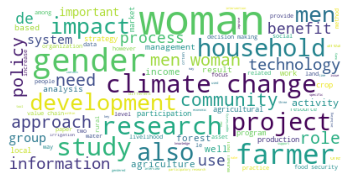

In [121]:
#Word cloud
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [122]:
from sklearn.feature_extraction.text import CountVectorizer
import re

##Building vocabulary
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)
list(cv.vocabulary_.keys())[:20]

['paper',
 'contributes',
 'understanding',
 'determinant',
 'food',
 'security',
 'bias',
 'link',
 'gender',
 'household',
 'head',
 'using',
 'detailed',
 'farm',
 'plot',
 'level',
 'survey',
 'data',
 'division',
 'rural']

            Word  Freq
0          woman   934
1         gender   861
2       research   497
3            men   335
4         farmer   316
5        climate   315
6         change   304
7      household   290
8          study   266
9             de   247
10   development   245
11      resource   232
12  agricultural   226
13        forest   221
14          food   211
15   agriculture   193
16       project   192
17    management   187
18        impact   184
19        access   181


[Text(0, 0, 'woman'),
 Text(0, 0, 'gender'),
 Text(0, 0, 'research'),
 Text(0, 0, 'men'),
 Text(0, 0, 'farmer'),
 Text(0, 0, 'climate'),
 Text(0, 0, 'change'),
 Text(0, 0, 'household'),
 Text(0, 0, 'study'),
 Text(0, 0, 'de'),
 Text(0, 0, 'development'),
 Text(0, 0, 'resource'),
 Text(0, 0, 'agricultural'),
 Text(0, 0, 'forest'),
 Text(0, 0, 'food'),
 Text(0, 0, 'agriculture'),
 Text(0, 0, 'project'),
 Text(0, 0, 'management'),
 Text(0, 0, 'impact'),
 Text(0, 0, 'access')]

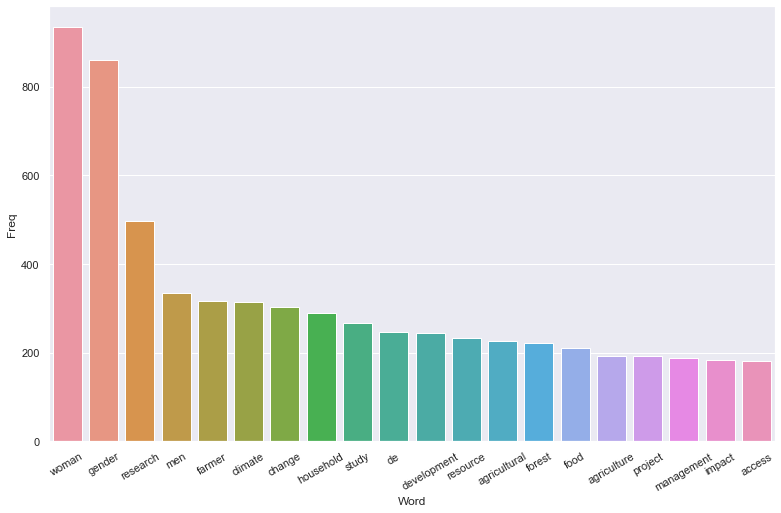

In [123]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                   Bi-gram  Freq
0           climate change   193
1                men woman   124
2            food security    86
3              value chain    80
4          decision making    75
5                woman men    67
6   participatory research    63
7         natural resource    47
8                    de la    44
9    agricultural research    41
10          livestock fish    41
11         gender analysis    40
12      gender integration    39
13              gender gap    38
14     resource management    37
15       forest management    36
16              case study    35
17        headed household    33
18          book different    33
19        different kettle    33


[Text(0, 0, 'climate change'),
 Text(0, 0, 'men woman'),
 Text(0, 0, 'food security'),
 Text(0, 0, 'value chain'),
 Text(0, 0, 'decision making'),
 Text(0, 0, 'woman men'),
 Text(0, 0, 'participatory research'),
 Text(0, 0, 'natural resource'),
 Text(0, 0, 'de la'),
 Text(0, 0, 'agricultural research'),
 Text(0, 0, 'livestock fish'),
 Text(0, 0, 'gender analysis'),
 Text(0, 0, 'gender integration'),
 Text(0, 0, 'gender gap'),
 Text(0, 0, 'resource management'),
 Text(0, 0, 'forest management'),
 Text(0, 0, 'case study'),
 Text(0, 0, 'headed household'),
 Text(0, 0, 'book different'),
 Text(0, 0, 'different kettle')]

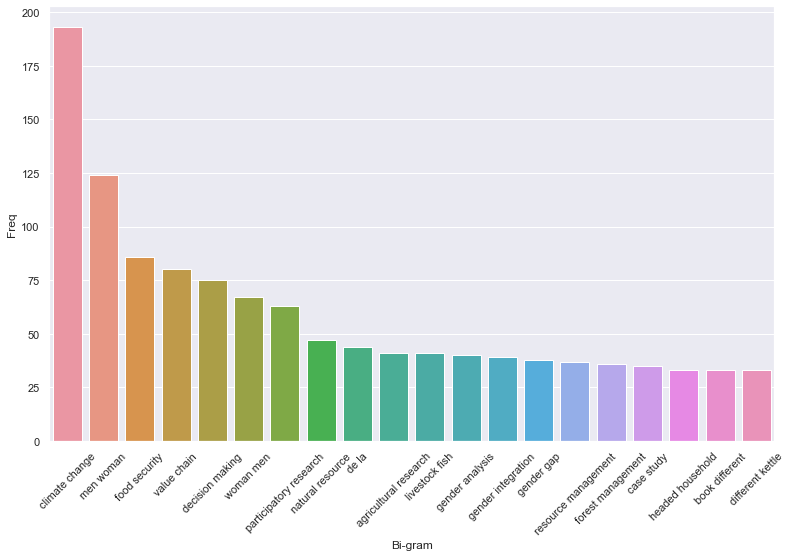

In [124]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                        Tri-gram  Freq
0          book different kettle    33
1          different kettle fish    33
2             kettle fish gender    33
3        fish gender integration    33
4   gender integration livestock    33
5     integration livestock fish    33
6        livestock fish research    33
7             fish research http    33
8              research http hdl    33
9                http hdl handle    33
10                hdl handle net    33
11    climate change agriculture    30
12        cgiar research program    27
13     agriculture food security    26
14   natural resource management    26
15       change agriculture food    22
16       female headed household    20
17     climate change adaptation    17
18           ilri book different    17
19      research program climate    16


[Text(0, 0, 'book different kettle'),
 Text(0, 0, 'different kettle fish'),
 Text(0, 0, 'kettle fish gender'),
 Text(0, 0, 'fish gender integration'),
 Text(0, 0, 'gender integration livestock'),
 Text(0, 0, 'integration livestock fish'),
 Text(0, 0, 'livestock fish research'),
 Text(0, 0, 'fish research http'),
 Text(0, 0, 'research http hdl'),
 Text(0, 0, 'http hdl handle'),
 Text(0, 0, 'hdl handle net'),
 Text(0, 0, 'climate change agriculture'),
 Text(0, 0, 'cgiar research program'),
 Text(0, 0, 'agriculture food security'),
 Text(0, 0, 'natural resource management'),
 Text(0, 0, 'change agriculture food'),
 Text(0, 0, 'female headed household'),
 Text(0, 0, 'climate change adaptation'),
 Text(0, 0, 'ilri book different'),
 Text(0, 0, 'research program climate')]

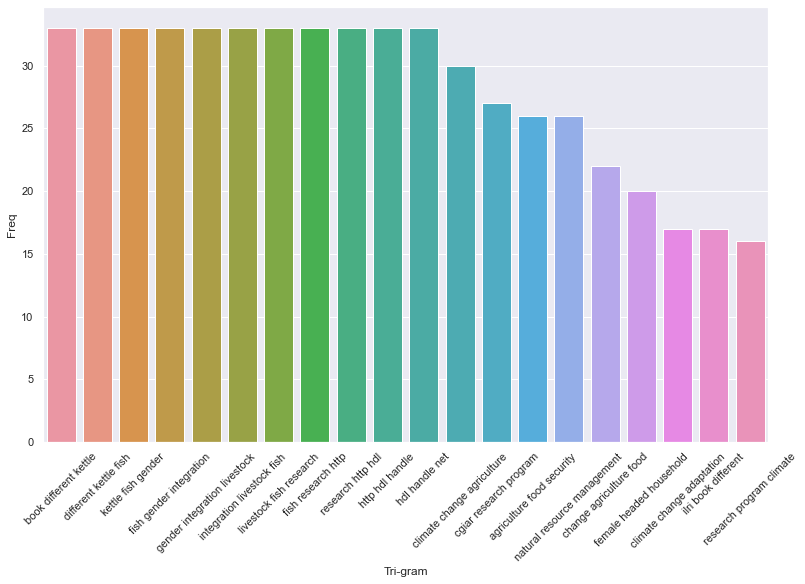

In [125]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [126]:
##TF-IDF 
## term frequency - inverse document frequency
## allow to prevent the dilution of specific keywords due to the large frequency of common words

from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix

#Function for sorting tf_idf in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [129]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
for doc in corpus:
    # fetch document for which keywords needs to be extracted
    #doc=corpus[0]
 
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,5)

    # now print the results
    print("\nAbstract:")
    print(doc)
    print("\nKeywords:")
    for k in keywords:
        print(k,keywords[k])
        
    break


Abstract:
paper contributes understanding determinant food security bias link gender household head food security using detailed farm household plot level survey data division rural kenya parametric non parametric econometric technique used ensure robustness result econometric analysis since assumption pooled regression rejected run separate food security regression plot level male headed household mhhs female headed household fhhs descriptive econometrics result show fhhs general likely food insecure compared male counterpart analysis reveals female headed household food security increase quality extension worker land quality farm size distance market reduces probability food security quality extension staff policy maker focus improving skill extension staff efficient effective dissemination technology important information impact food security since area expansion infeasible due land scarcity kenya policy maker focusing land augmenting practice help farm household escape food insecu

In [170]:
from nltk.util import ngrams 

### now compare these results with the keywords that have been entered
## first globaly
keywords = subjectsDC + subjectsOther

c= Counter(ngrams(keywords, 1))

#print(c.most_common(50))

df = pd.DataFrame.from_dict(c, orient='index').reset_index()
df = df.rename(columns={'index':'Word', 0:'Freq'})
df = df.sort_values(by=['Freq'], ascending=False)
df = df.iloc[0:20]

df

,Word,Freq
5,"(gender,)",701
23,"(women,)",366
24,"(livestock,)",274
1,"(agriculture,)",258
2,"(food security,)",158
41,"(research,)",124
0,"(climate change,)",118
762,"(gender and equity,)",100
93,"(fish,)",83
354,"(markets,)",79


[Text(0, 0, "('gender',)"),
 Text(0, 0, "('women',)"),
 Text(0, 0, "('livestock',)"),
 Text(0, 0, "('agriculture',)"),
 Text(0, 0, "('food security',)"),
 Text(0, 0, "('research',)"),
 Text(0, 0, "('climate change',)"),
 Text(0, 0, "('gender and equity',)"),
 Text(0, 0, "('fish',)"),
 Text(0, 0, "('markets',)"),
 Text(0, 0, "('gender and social inclusion',)"),
 Text(0, 0, "('participatory research',)"),
 Text(0, 0, "('livelihoods',)"),
 Text(0, 0, "('value chains',)"),
 Text(0, 0, "('forest governance and community forestry',)"),
 Text(0, 0, "('forestry',)"),
 Text(0, 0, "('participatory approaches',)"),
 Text(0, 0, "('role of women',)"),
 Text(0, 0, "('forest management',)"),
 Text(0, 0, "('plant breeding',)")]

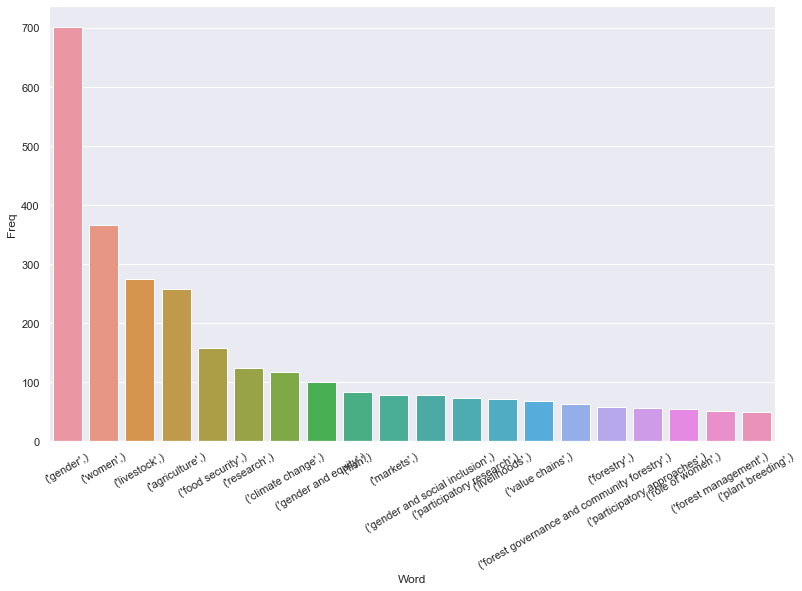

In [171]:
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)